In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
 

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainloader = DataLoader(trainset,batch_size=32,shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane','car','bird','cat','deer','dog','forg','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img/2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1,2,0)))
    plt.show()

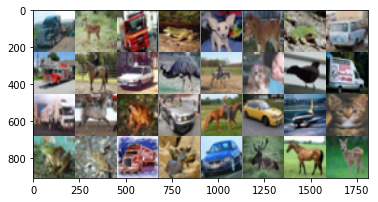

truck  deer truck  forg   dog horse  forg   car truck horse   car  bird horse   dog  bird truck truck horse  forg   car horse   car plane   cat  forg  forg truck  deer   car  deer horse  deer


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%classes[labels[j]] for j in range(32)))

In [ ]:
class VGG(nn.Module) :
    def __init__(self, num_classes) :
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, pading=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_sze=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
        self._initialize_weights()
    def forward(self, x) :
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

In [ ]:
device = torch.device("cuda")
print(device) 
net = VGG()
net.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, lables = data
        inputs = inputs#.to(device)
        lables = lables#.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d,%5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
print('Finished Training')
torch.save(net, './model')

In [ ]:
net = torch.load('./model')
print(net)
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(32)))

In [ ]:
images, labels = images,labels#.to(device), labels.to(device) 
outputs = net(images)
predicted = torch.argmax(outputs,1)
print('Predicted: ',' '.join('%5s'%classes[predicted[j]] for j in range(32))) 
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images#.to(device)
        labels = labels#.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
 print('Accuracy of the network on the 50000 train images: %d %%'%(100*correct/total))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images#.to(device)
        labels = labels#.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%'%(100*correct/total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images#.to(device)
        labels = labels#.to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data,1)
        c = (predicted== labels)
        if len(c) == 16:
            for i in range(16):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += c[i].item()
        else:
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%'%(classes[i], 100*class_correct[i]/class_total[i]))